<a href="https://colab.research.google.com/github/PGM-Lab/2023-probai-private/blob/main/Day2-BeforeLunch/notebooks/CAVI-linreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
import matplotlib.colors as mcolors
from scipy.stats import multivariate_normal, norm
import time
import torch
import torch.nn as nn
#from IPython.display import display, clear_output
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings('ignore')

# 1. Dataset and miscellaneous

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
 
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially. 

In [2]:
np.random.seed(42)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df.sample(frac=1)
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df = df[["cont_africa", "rugged", "rgdppc_2000"]]

# Divide the data into predictors and response and store the data in numpy arrays organized in a dictionary with one 
# element for african and non-african nations, respectively.
data = np.array(df)
x_data = {'non-african': data[data[:, 0] == 0, 1].reshape(-1,1), 'african': data[data[:, 0] == 1, 1].reshape(-1,1)}
y_data = {'non-african': data[data[:, 0] == 0, -1], 'african': data[data[:, 0] == 1, -1]}

print(f"Number of african countries: {x_data['african'].shape[0]}")
print(f"Number of non-african countries: {x_data['non-african'].shape[0]}")

Number of african countries: 49
Number of non-african countries: 121


In [3]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,rgdppc_2000
69,0,1.098,10.154169
206,0,0.284,8.207281
9,0,2.688,7.792343
109,0,0.540,7.527828
196,0,0.715,10.161994
93,0,0.346,9.489761
15,1,1.780,6.432380
55,0,0.003,8.688069
227,0,1.729,8.062162
201,1,0.419,6.710706


In [4]:
def prepare_figure(title='Scatter plot of data', x_data_: dict = None, y_data_: dict = None):
    """
    Plot the data and return the figure axis for possible subsequent additional plotting.
    :param title: Title of the plot
    :param x_data_: dictionary with data for the prdictor variable
    :param y_data_: dictionary with data for the response variable.
    :return: Figure axis.
    """
    if x_data_ is None and y_data_ is None:
        x_data_ = x_data
        y_data_ = y_data

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
    fig.suptitle(title, fontsize=16)

    for idx, cont in enumerate(x_data):
        ax[idx].scatter(x_data_[cont], y_data_[cont], c='black')
        ax[idx].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)",
                    title=f"{cont} nations")

    return ax

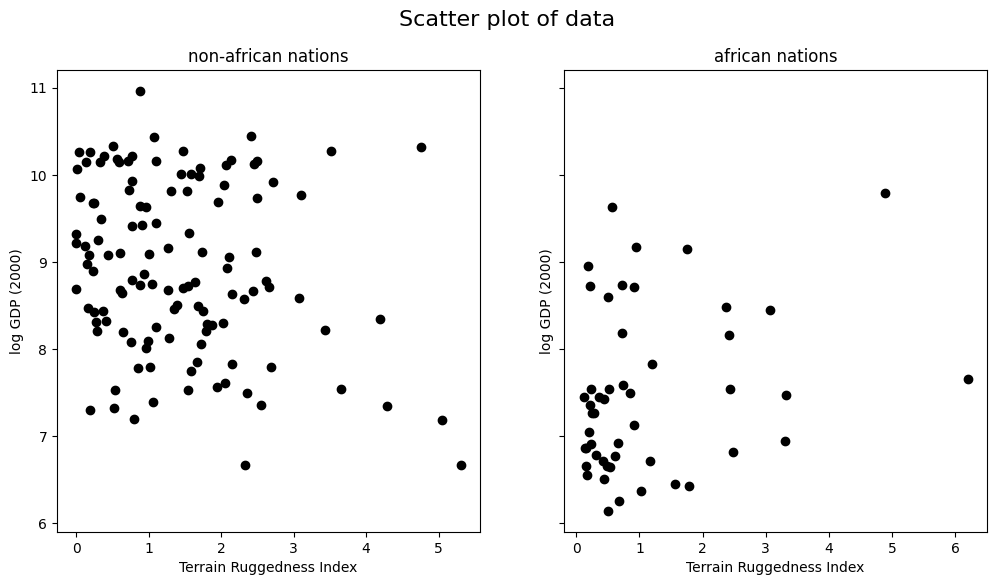

In [5]:
# Let's display the data
prepare_figure('Scatter plot of data')
plt.show()

## 1.1 Helper functions

In [6]:
def get_data_subsets(x_data_: dict, y_data_: dict, frac: float = 1, verbose=True):
    """
    Sample a subset of the data sets. Both data sets are again dictionaries with elements for
    african and non-african nations.
    :param x_data_: Dictionary with data for the predictor variable
    :param y_data_: Dictionary with data for the response variable
    :param frac: fraction of the data to be sampled
    :param verbose: How much detail should be displayed
    :return: Four dictionaries, two for each of the subsets.
    """

    x_data_ic = {}
    y_data_ic = {}
    x_data_ec = {}
    y_data_ec = {}

    # Iterate over the two keys (african and non-african) and pick out the data
    for cont in x_data_.keys():
        indices = np.random.choice(x_data_[cont].shape[0], int(x_data_[cont].shape[0] * frac), replace=False)
        mask = np.zeros(x_data_[cont].shape[0], dtype=bool)
        mask[indices] = True
        x_data_ic[cont] = x_data_[cont][mask, :]
        y_data_ic[cont] = y_data_[cont][mask]
        x_data_ec[cont] = x_data_[cont][~mask, :]
        y_data_ec[cont] = y_data_[cont][~mask]

    if verbose:
        for cont in x_data_ic.keys():
            print(f"{cont} entries: {x_data_ic[cont].shape[0]}")

    return x_data_ic, y_data_ic, x_data_ec, y_data_ec

In [7]:
def plot_model(ax, x_data_: dict = None, model: dict = None, linewith: int = 2,
               label: str = None, line_color: str = 'red', num_samples: int = 0):
    """
    Plot the model using the figure axes in ax
    :param ax: Figure axes
    :param x_data_: dictionary with data for the predictor variable
    :param model: The model (i.e., weights/parameters and possibly covariance) in a dictionary with one element for
    african and non-african.
    :param linewith: width of line to be plotted
    :param label: the label to go with the model plot
    :param line_color: color of line to be plotted
    :param num_samples: If the model also contains a covariance matrix we treat the weights 'w' as mean values and
    sample realizations of the model from the weight distribution.
    :return: Figure axes.
    """
    if x_data_ is None:
        x_data_ = x_data

    if model is None:
        print("Ups, no model supplied")
    for idx, cont in enumerate(model):
        # We treat the first element in the weight matrix as the bias hence we add a constant one column to the data
        x_aug = np.c_[np.ones(x_data_[cont].shape[0]), x_data_[cont]]

        # Sample from the distribution over the weights if a covariance matrix is given.
        if num_samples > 0 and 'cov' in model[cont]:
            for _ in range(num_samples):
                w_sample = np.random.multivariate_normal(mean=model[cont]['w'],
                                                         cov=model[cont]['cov'])
                ax[idx].plot(x_data[cont], x_aug @ w_sample , 'g-', alpha=.05)

        ax[idx].plot(x_data_[cont], x_aug @ model[cont]['w'],
                     color=line_color,
                     linewidth=linewith,
                     label=label)
        if label is not None:
            ax[idx].legend()
    return ax

# 1. Linear regression

Linear regression is one of the most commonly used supervised learning tasks in machine learning. Suppose we are given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of linear regression is to fit a function to the data of the form:

$$ y = w X + b + \epsilon, $$

where $w$ and $b$ are learnable parameters and $\epsilon$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

Let's first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we'll see how to incorporate uncertainty into our estimates.

## 1.1 Model
We would like to predict log GDP per capita of a nation as a function of whether the nation is in Africa and its Terrain Ruggedness Index. As indicated by the data partitioning above, we will make one linear regression model for african and non-african nations, respectively. 

To sprcify our regression model, we will define a specific object encapsulating the model.  Our input `x_data` is a tensor of size $N \times 1$ and our output `y_data` is a tensor of size $N \times 1$.  The method `predict(self,x_data)` defines a linear transformation of the form $Xw + b$ where $w$ is the weight matrix and $b$ is the additive bias.

The parameters of the model are defined using ``torch.nn.Parameter``, and will be learned during training.

In [8]:
class RegressionModel():
    def __init__(self):
        self.w = torch.nn.Parameter(torch.zeros(1, 1))
        self.b = torch.nn.Parameter(torch.zeros(1, 1))

    def params(self):
        return {"b": self.b, "w": self.w}

    def predict(self, x_data):
        return (self.b + torch.mm(self.w, torch.t(x_data))).squeeze(0)

## 1.2 Training
We will use the mean squared error (MSE) as our loss and Adam as our optimizer. We would like to optimize the parameters of the `regression_model` neural net above. We will use a somewhat large learning rate of `0.05` and run for 1000 iterations.

In [9]:
def least_squares_solution(x_data, y_data, verbose=True):
    regression_model = RegressionModel()
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(regression_model.params().values(), lr=0.05)
    num_iterations = 1000

    param = {}
    for cont in x_data.keys():
        param[cont] = {}
        if verbose:
            print(f"Learning model for {cont} nations")
        for j in range(num_iterations):
            # run the model forward on the data
            y_pred = regression_model.predict(torch.tensor(x_data[cont], dtype=torch.float))
            # calculate the mse loss
            loss = loss_fn(y_pred, torch.tensor(y_data[cont], dtype=torch.float))
            # initialize gradients to zero
            optim.zero_grad()
            # backpropagate
            loss.backward()
            # take a gradient step
            optim.step()
            if (j + 1) % 500 == 0 and verbose:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

        # Store the learned parameters 
        param[cont]['w'] = np.r_[regression_model.params()['b'].detach().numpy().copy().flatten(),
                      np.transpose(regression_model.params()['w'].detach().numpy()).copy().flatten()]
    # Inspect learned parameters
    if verbose:
        print("Learned parameters:")
        for cont in param.keys():
            print(f"{cont}: weights = {param[cont]['w']}")

    return param

In [10]:
# Learn the model
model_lr = least_squares_solution(x_data, y_data)

Learning model for non-african nations
[iteration 0500] loss: 124.0177
[iteration 1000] loss: 108.7802
Learning model for african nations
[iteration 0500] loss: 39.1070
[iteration 1000] loss: 39.1017
Learned parameters:
non-african: weights = [ 9.220676   -0.20161663]
african: weights = [7.275192   0.19053152]


## 1.3 Evaluating the model

We now plot the regression line learned for african and non-african nations relating the rugeedness index with the GDP of the country.

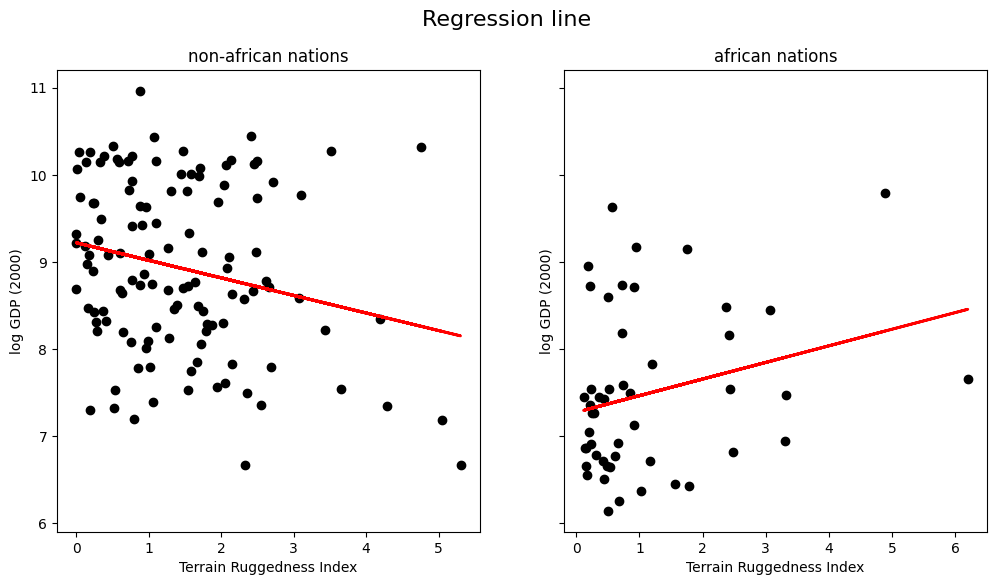

In [11]:
ax = prepare_figure(title='Regression line')
plot_model(ax, model=model_lr)
plt.show()

## 1.4 The relationship between ruggedness and log GPD

Using this analysis, we can estimate the relationship between ruggedness and log GPD. As can be seen, this relationship is positive for African nations, but negative for Non African Nations.

In [12]:
print(f"Slope for non-african nations: {model_lr['non-african']['w'][1]}")
print(f"Slope for african nations: {model_lr['african']['w'][1]}")

Slope for non-african nations: -0.20161662995815277
Slope for african nations: 0.19053152203559875


## 1.5 The effect of outliers

In [13]:
# Add a couple of 'outliers' to the data
x_data_with_outliers = x_data.copy()
y_data_with_outliers = y_data.copy()
x_data_with_outliers['african'] = np.concatenate((x_data['african'], [[6]], [[5.5]]), axis=0)
x_data_with_outliers['non-african'] = np.concatenate((x_data['non-african'], [[4]], [[5.2]]), axis=0)
y_data_with_outliers['african'] = np.concatenate((y_data['african'], [5.2], [6.3]), axis=0)
y_data_with_outliers['non-african'] = np.concatenate((y_data['non-african'], [10], [11]), axis=0)

# Learn a new model with the modified dataset
model_outlier = least_squares_solution(x_data_with_outliers, y_data_with_outliers)

Learning model for non-african nations
[iteration 0500] loss: 130.5406
[iteration 1000] loss: 117.9101
Learning model for african nations
[iteration 0500] loss: 48.3504
[iteration 1000] loss: 48.3493
Learned parameters:
non-african: weights = [ 9.130556   -0.11606622]
african: weights = [ 7.4270163e+00 -6.5712752e-03]


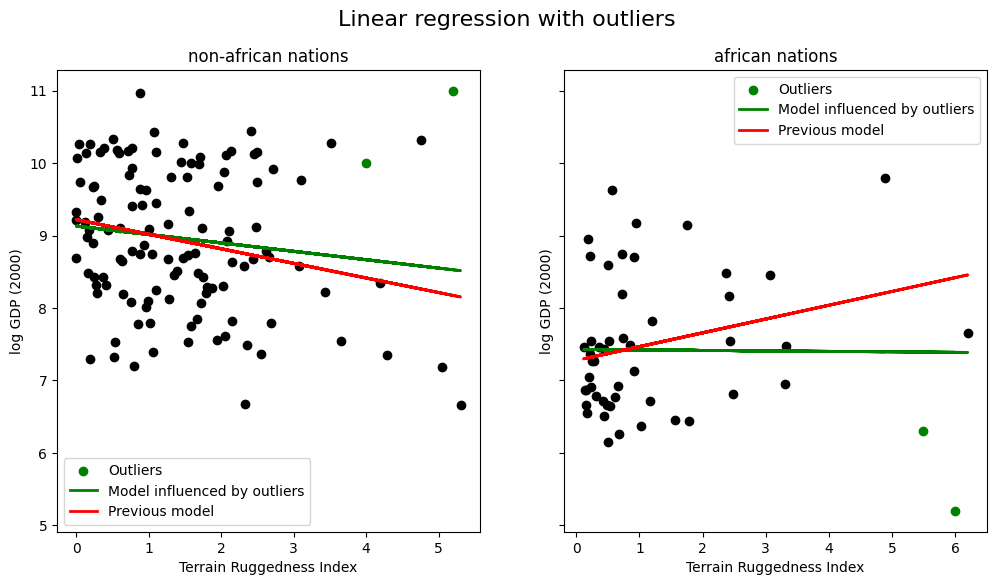

In [14]:
ax = prepare_figure("Linear regression with outliers")
ax[0].scatter(x_data_with_outliers['non-african'][-2:],
              y_data_with_outliers['non-african'][-2:], c='green', label='Outliers')
ax[1].scatter(x_data_with_outliers['african'][-2:],
              y_data_with_outliers['african'][-2:], c='green', label='Outliers')

plot_model(ax, x_data_with_outliers, model=model_outlier, label='Model influenced by outliers', line_color='green')
plot_model(ax, x_data_with_outliers, model=model_lr, label='Previous model')

plt.show()

In [15]:
# What can we now say about the slope?
print(f"Slope for non-african nations: {model_outlier['non-african']['w'][1]}")
print(f"Slope for african nations: {model_outlier['african']['w'][1]}")

Slope for non-african nations: -0.11606622487306595
Slope for african nations: -0.006571275182068348


# 2. Bayesian linear regressison

Following the approach from earlier today, we will model the data using a Bayesian linear regression model:
<img src="Bayesian_linear_regression.png" style="width: 400px;"/>

The quantitative part of the model is specified as: 
- Number of data dim: $M$
- Number of data inst: $N$
- $Y_{i}|\{{\bf w}, {\bf x}_i, \theta \} \sim \mathcal{N}({\bf w}^T{\bf x}_i, 1/\theta)$    
- ${\bf W} \sim {\mathcal N}({\bf 0}, \gamma_w^{-1}{\bf I}_{M\times M})$
- $b\sim {\mathcal N}(0,\gamma_b^{-1})$

## 2.1 Helper-routine: Calculate ELBO

In [16]:
def calculate_ELBO(x_data, y_data, gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec):
    """
    Helper routine: Calculate ELBO. Data is the sampled x and y values, gamma is the prior precision over the 
    weights and theta is the prior precision associated with y. Everything prefixed a 'q' relates to the 
    variational posterior.
    
    Note: This function obviously only works for this particular model and is not a general solution.

    :param x_data: The predictors
    :param y_data: The response variable
    :param gamma_w: prior precision for the weights
    :param gamma_b: prior precision for the intercept
    :param theta: prior precision for y
    :param q_w_mean: VB posterior mean for the distribution of the weights w 
    :param q_w_prec: VB posterior precision for the distribution of the weights w 
    :param q_b_mean: VB posterior mean for the intercept b
    :param q_b_prec: VB posterior precision for the intercept b
    :return: the ELBO
    """
    
    # We calculate the ELBO as E_q log p(y,x,w,b) - E_q log q(w,b), where
    # log p(y,x,w) = sum_i log p(y|x,w,b) + log p(w) + log p(b)
    # log q(w,b) = log q(w) + log q(b)

    M = x_data.shape[1]

    # E_q log p(w)
    E_log_p = -0.5 * M * np.log(2 * np.pi) + 0.5 * M * np.log(gamma_w) - 0.5 * gamma_w * np.sum(np.diagonal(np.linalg.inv(q_w_prec))
                                                                                    + (q_w_mean*q_w_mean).flatten())
    # E_q log p(b)
    E_log_p += -0.5 * np.log(2 * np.pi) + 0.5 * np.log(gamma_b) - 0.5 * gamma_b * (1/q_b_prec + q_b_mean**2)

    # sum_i E_q log p(y|x,w,b)
    E_w_w = np.linalg.inv(q_w_prec) + q_w_mean @ q_w_mean.transpose()
    E_b_b = 1/q_b_prec + q_b_mean**2
    for i in range(x_data.shape[0]):
        E_x_ww_x = np.matmul(x_data[i, :].transpose(), np.matmul(E_w_w, x_data[i, :]))
        E_log_p += -0.5 * np.log(2 * np.pi) + 0.5 * np.log(theta) \
                   - 0.5 * theta * (y_data[i]**2 + E_x_ww_x + E_b_b
                                    + 2 * q_b_mean * np.matmul(q_w_mean.transpose(), x_data[i, :])
                                    - 2 * y_data[i] * np.matmul(q_w_mean.transpose(), x_data[i,:])
                                    - 2 * y_data[i] * q_b_mean)

    # Entropy of q_b
    ent = 0.5 * np.log(1 * np.pi * np.exp(1) / q_b_prec)
    ent += 0.5 * np.log(np.linalg.det(2 * np.pi * np.exp(1) * np.linalg.inv(q_w_prec)))

    return E_log_p + ent

## 2.2 Variational solution
First we consider a full mean filed approach, where the variational approximation factorizes as
$$
q({\bf w}, b) = q(b)\prod _{i=1}^Mq(w_i)
$$
Actually, in our specific case we only have one weight besides the bias, hence the approximation actually simplies to
$$
q(w, b) = q(b)q(w).
$$

### 2.2.1 Updating equations

In [17]:
# The variational updating rule for weight component
def update_w_comp(x_data, y_data, gamma_w, theta, q_w_mean, q_w_prec, q_b_mean, comp):
    """
    The variational updating rule for a specific weight component. This updating function is defined for a general
    Bayesian linear regression model, which can contain multiple predictor variables. 'comp' is used to index the
    specific component to be updated.
    :param x_data: A numpy array of size N x M with data for the predictor variable. In our case, M=1.
    :param y_data: A numpy array of size N x 1.
    :param gamma_w: precision for the weights.
    :param theta: prior precision for y.
    :param q_w_mean: VB posterior mean for the distribution of the weights w
    :param q_w_prec: VB posterior precision for the distribution of the weights w
    :param q_b_mean: VB posterior mean for the intercept b
    :param comp: The weight component to be updated.
    :return: The updated precision and mean value for the weight component.
    """
    # Lenght of weight vector
    M = x_data.shape[1]
    # The precision (a scalar)
    tau = gamma_w
    # The mean (a scalar)
    mu = 0.0
    for i in range(x_data.shape[0]):
        tau += theta * x_data[i, comp]**2
        mu += (y_data[i] - q_b_mean - (np.sum(x_data[i, :] @ q_w_mean) - x_data[i, comp]*q_w_mean[comp])) \
                * x_data[i, comp]
    mu = theta * 1/tau * mu

    # Update the appropriate entries in the mean vector and precision matrix
    q_w_prec[comp, comp] = tau
    q_w_mean[comp] = mu.item()

    return q_w_prec, q_w_mean

# The variational updating rule for the intercept
def update_b(x_data, y_data, gamma_b, theta, q_w_mean):
    """
    The variational updating rule for  the bias term
    :param x_data: A numpy array of size N x M with data for the predictor variable. In our case, M=1.
    :param y_data: A numpy array of size N x 1.
    :param gamma_b: precision for the bias term
    :param theta: prior precision for y
    :param q_w_mean: VB posterior mean for the distribution of the weights w
    :return: The updated precision and mean value for the bias term.
    """
    # The precision (a scalar)
    tau = (gamma_b + theta * x_data.shape[0])
    # The mean (a scalar)
    mu = 0
    for i in range(x_data.shape[0]):
        mu += (y_data[i] - q_w_mean.transpose() @ x_data[i, :])
    mu = 1/tau * theta * mu

    return tau, mu

### 2.2.2 Do the VB (full mean field)

In [18]:
def variational_solution(x_data, y_data, gamma_w: float = 1, gamma_b: float = 1, theta: float = 1, verbose=True):
    """
    Perform variational inference using the coordinate ascent updating rules. The two models (for african and
    non-african nations are learned independently.
    :param x_data: dictionary with data for the predictor variable
    :param y_data: dictionary with data for the response variable
    :param gamma_w: precision for the weight/slope term
    :param gamma_b: precision for the bias term
    :param theta: prior precision for y
    :param verbose: Do we want to display information from the updating process?
    :return: The model (i.e., mean and covariance) in a dictionary with one element for african and non-african.
    """
    param = {}

    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
        fig.suptitle("Evolution of ELBO", fontsize=16)
        
     # Do the learning for african and non-african nations
    for idx, cont in enumerate(x_data):
        param[cont] = {}
        M = x_data[cont].shape[1]
        q_w_mean = np.random.normal(0, 1, (1, 1))
        q_w_prec = np.array([[1]])
        q_b_mean = np.random.normal(0, 1)
        q_b_prec = 1
        elbos = []

        # Calculate ELBO
        this_lb = calculate_ELBO(x_data[cont], y_data[cont], gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec)
        elbos.append(this_lb)
        previous_lb = -np.inf
        # Start iterating
        if verbose:
            print("\n" + 100 * "=" + "\n   VB iterations:\n" + 100 * "=")
        for iteration in range(100):

            # Update the variational distributions
            for i in range(M):
                q_w_prec, q_w_mean = update_w_comp(x_data[cont], y_data[cont], gamma_w, theta, q_w_mean, q_w_prec, q_b_mean, i)
            q_b_prec, q_b_mean = update_b(x_data[cont], y_data[cont], gamma_b, theta, q_w_mean)

            this_lb = calculate_ELBO(x_data[cont], y_data[cont], gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec)
            elbos.append(this_lb)
            if verbose:
                print(f"Iteration {iteration:2d}. ELBO: {this_lb.item():13.7f}")
            if this_lb < previous_lb:
                raise ValueError("ELBO is decreasing. Something is wrong! Goodbye...")

            if iteration > 0 and np.abs((this_lb - previous_lb) / previous_lb) < 1E-8:
                # Very little improvement. We are done.
                break

            # If we didn't break we need to run again. Update the value for "previous"
            previous_lb = this_lb
        if verbose:
            print("\n" + 100 * "=" + "\n")

        param[cont]['w'] = np.r_[q_b_mean, q_w_mean.flatten()]
        param[cont]['cov'] = np.linalg.inv(np.diag(np.r_[q_b_prec, q_w_prec.flatten()]))

        if verbose:
            ax[idx].plot(range(len(elbos)), elbos, label='Mean field approximation: ELBO')
            ax[idx].set(xlabel="Number of iterations",
                        ylabel="ELBO",
                        title=f"{cont} nations")
            ax[idx].legend()

    plt.show()

    # Inspect learned parameters
    if verbose:
        print("Learned parameters:")
        for cont in param.keys():
            print(f"For {cont} nations")
            for name, value in param[cont].items():
                print(f"{name} = ")
                print(f"{value}")

    return param


   VB iterations:
Iteration  0. ELBO: -1120.0257786
Iteration  1. ELBO:  -556.9539743
Iteration  2. ELBO:  -343.4113872
Iteration  3. ELBO:  -262.4262692
Iteration  4. ELBO:  -231.7130077
Iteration  5. ELBO:  -220.0651338
Iteration  6. ELBO:  -215.6477272
Iteration  7. ELBO:  -213.9724446
Iteration  8. ELBO:  -213.3371007
Iteration  9. ELBO:  -213.0961493
Iteration 10. ELBO:  -213.0047695
Iteration 11. ELBO:  -212.9701141
Iteration 12. ELBO:  -212.9569712
Iteration 13. ELBO:  -212.9519868
Iteration 14. ELBO:  -212.9500964
Iteration 15. ELBO:  -212.9493796
Iteration 16. ELBO:  -212.9491077
Iteration 17. ELBO:  -212.9490046
Iteration 18. ELBO:  -212.9489655
Iteration 19. ELBO:  -212.9489506
Iteration 20. ELBO:  -212.9489450
Iteration 21. ELBO:  -212.9489429
Iteration 22. ELBO:  -212.9489421



   VB iterations:
Iteration  0. ELBO:  -644.9706357
Iteration  1. ELBO:  -193.1931466
Iteration  2. ELBO:  -112.4884047
Iteration  3. ELBO:   -98.0714506
Iteration  4. ELBO:   -95.4960310
Iteratio

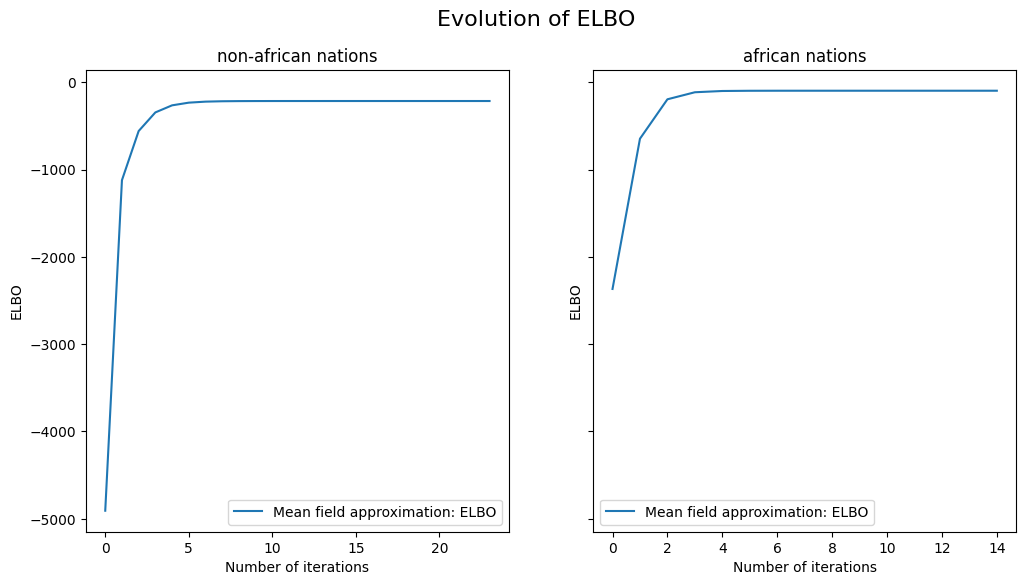

Learned parameters:
For non-african nations
w = 
[ 9.02443661 -0.11561238]
cov = 
[[0.00819672 0.        ]
 [0.         0.00253807]]
For african nations
w = 
[7.02566602 0.28617345]
cov = 
[[0.02       0.        ]
 [0.         0.00719424]]


In [19]:
model_mf = variational_solution(x_data, y_data, gamma_w=1, gamma_b=1, theta=1)

### 2.2.3 Model evaluation

To get a sense of the robustness of the model we draw samples from the posterior variational distributions over the weights and intercept; each sample correspond to a regression line

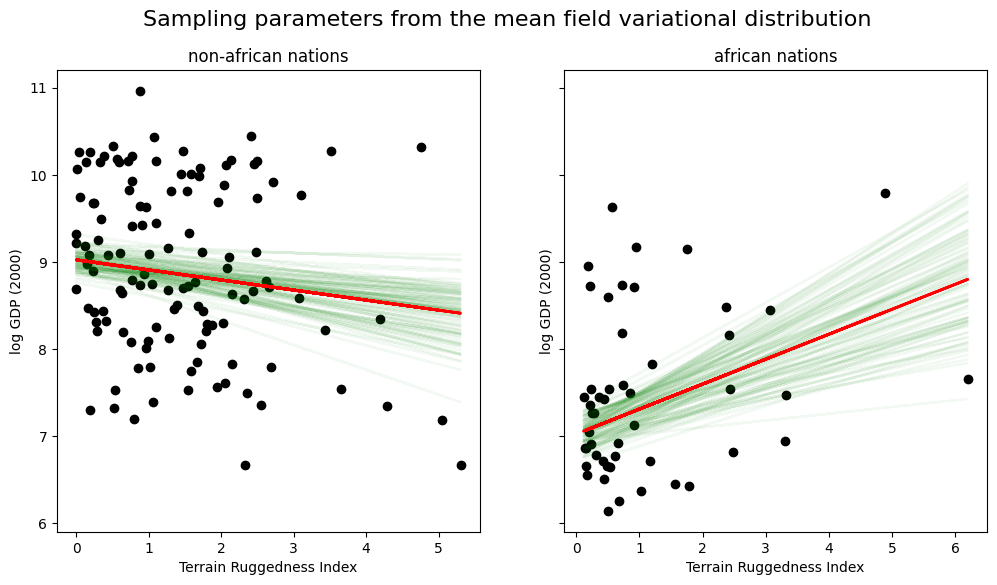

In [20]:
ax = prepare_figure("Sampling parameters from the mean field variational distribution")
plot_model(ax, model=model_mf, num_samples=100)
plt.show()

## 2.3 Bayes solution

### 2.3.1 Updating equations

In [21]:
# Calculate the exact posterior over the model parameters
def bayes_solution(x_data: dict, y_data: dict, gamma_w: float = 1, gamma_b: float = 1, theta: float = 1, verbose=True):
    """
    Calculate the exact posterior over the model parameters
    :param x_data: dictionary with data for the predictor variable
    :param y_data: dictionary with data for the response variable
    :param gamma_w: precision for the weight/slope term
    :param gamma_b: precision for the bias term
    :param theta: prior precision for y
    :param verbose: Do we want to display information from the updating process?
    :return: The learned model in the form of a dictionary
    """
    param = {}
    for cont in x_data.keys():
        param[cont] = {}
        x_aug = np.c_[np.ones(x_data[cont].shape[0]), x_data[cont]]
        prior_cov = np.diag([1. / gamma_b] + [1. / gamma_w])
        prior_mean = np.zeros(x_aug.shape[1])
        param[cont]['cov'] = np.linalg.inv(np.linalg.inv(prior_cov) + theta * np.transpose(x_aug) @ x_aug)
        param[cont]['w'] = param[cont]['cov'] @ (np.linalg.inv(prior_cov) @ prior_mean + theta * np.transpose(x_aug) @ y_data[cont])

    # Inspect learned parameters
    if verbose:
        print("Learned parameters:")
        for cont in param.keys():
            print(f"For {cont} nations")
            for name, value in param[cont].items():
                print(f"{name} = ")
                print(f"{value}")

    return param

In [22]:
model_bayes = bayes_solution(x_data, y_data, gamma_w=1, gamma_b=1, theta=1)

Learned parameters:
For non-african nations
cov = 
[[ 0.02133614 -0.00930554]
 [-0.00930554  0.00659033]]
w = 
[ 9.02455057 -0.11569308]
For african nations
cov = 
[[ 0.0346414  -0.01346286]
 [-0.01346286  0.01237919]]
w = 
[7.02572114 0.28612277]


### 2.3.1 Model evaluation

To get a sense of the robustness of the model we draw samples from the posterior distributions over the weights and intercept; each sample correspond to a regression line

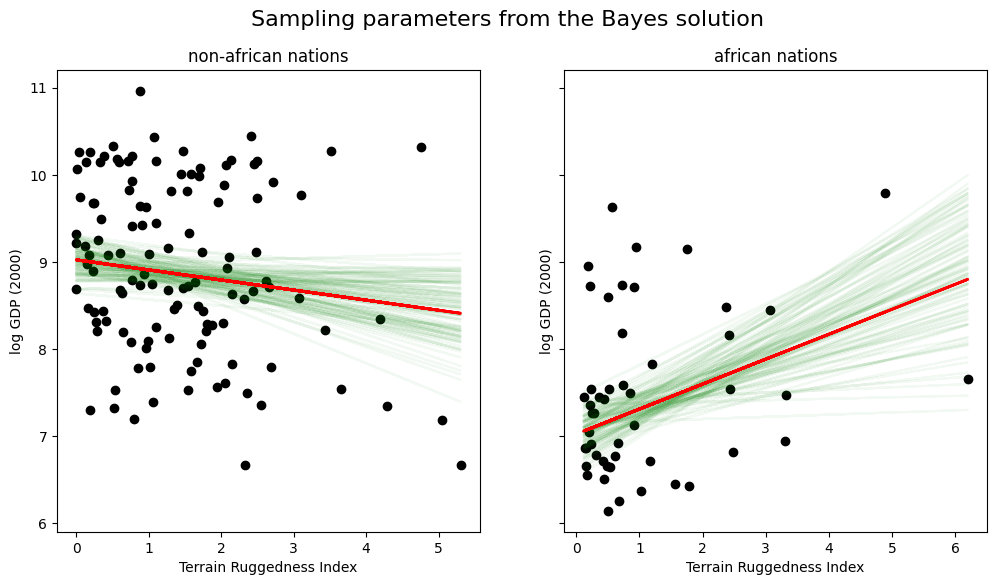

In [23]:
ax = prepare_figure("Sampling parameters from the Bayes solution")
plot_model(ax, model=model_bayes, num_samples=100)
plt.show()

Recreating the plots for the variational solution can make the comparison easier

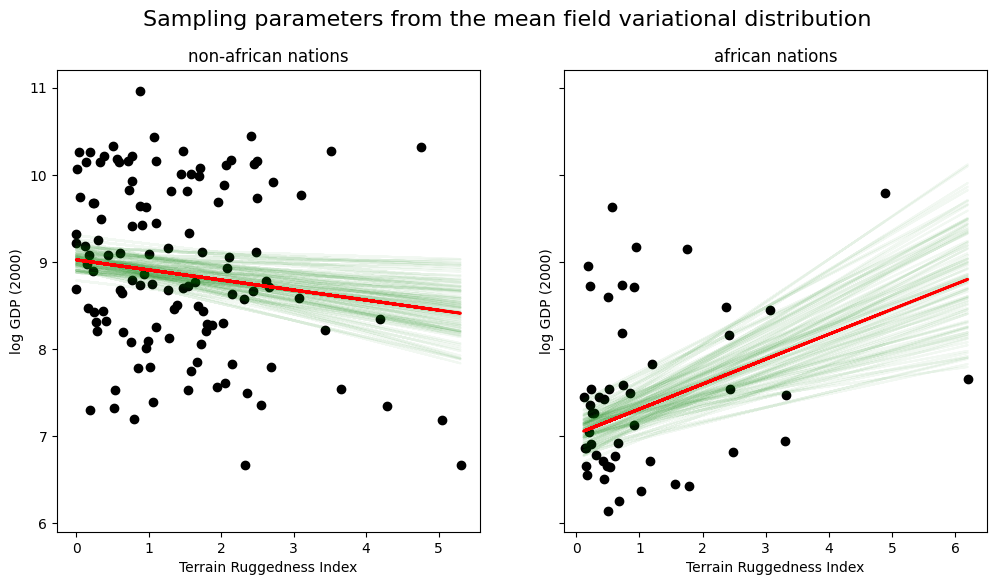

In [24]:
ax = prepare_figure("Sampling parameters from the mean field variational distribution")
plot_model(ax, model=model_mf, num_samples=100)
plt.show()

# 3 Model comparison

## 3.1 Additional helper functions

### 3.1.1 Visualizing bivariate densities

In [25]:
def density_plt(model_list: list):
    """
    Make a density plot of the models in the list. The first model is assumed to be the Bayes solution, based on which 
    the coordinate axes are defined. 
    """

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle("Density plots", fontsize=16)

    # We assume that the first model in the list is the Bayes model
    model_bayes = model_list[0]
    x_mesh = {}
    y_mesh = {}
    for cont in model_bayes.keys():
        x = np.linspace(model_bayes[cont]['w'][0] - 5 * model_bayes[cont]['cov'][0, 0],
                        model_bayes[cont]['w'][0] + 5 * model_bayes[cont]['cov'][0, 0], 100)
        y = np.linspace(model_bayes[cont]['w'][1] - 5 * model_bayes[cont]['cov'][1, 1],
                        model_bayes[cont]['w'][1] + 5 * model_bayes[cont]['cov'][1, 1], 100)
        x_mesh[cont], y_mesh[cont] = np.meshgrid(x, y)

    for model_idx, model in enumerate(model_list):
        for idx, cont in enumerate(model):
            dist = multivariate_normal(mean=model[cont]['w'], cov=model[cont]['cov'])
            input_vector = np.vstack([x_mesh[cont].flatten(), y_mesh[cont].flatten()]).T
            value = dist.pdf(input_vector).reshape(x_mesh[cont].shape)
            ax[idx].contour(
                x_mesh[cont], y_mesh[cont], value,
                linewidths=1.,
                linestyles='solid',
                levels=3,
                colors = list(mcolors.BASE_COLORS)[model_idx]
            )
            ax[idx].set(xlabel="$w_0$",
                        ylabel="$w_1$",
                        title=f"{cont} nations")
    plt.show()

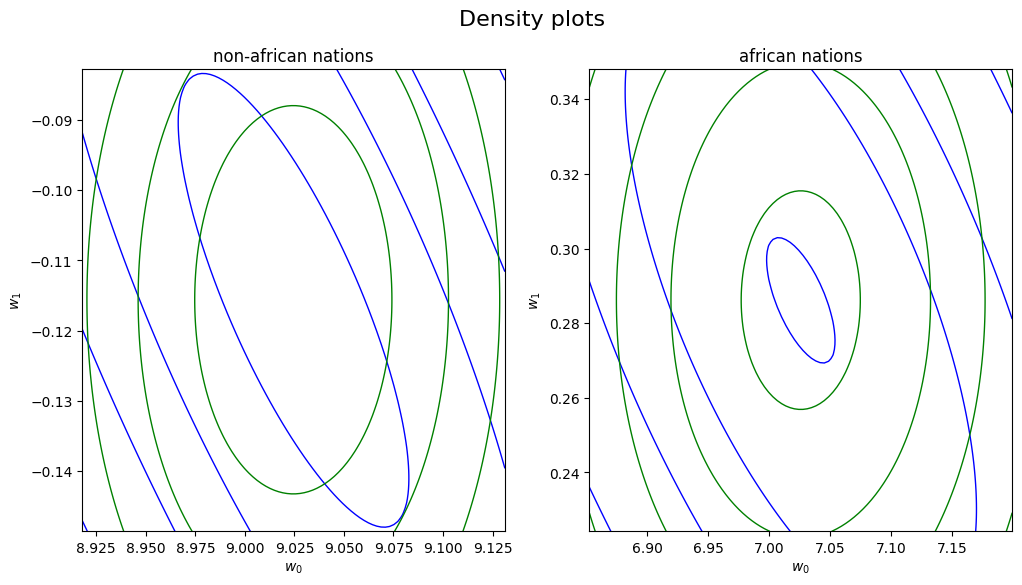

In [26]:
density_plt([model_bayes, model_mf])

### 3.1.2 Visualizing the marginals

In [27]:
def marginal_plot(model_bayes: dict, model_mf: dict, num_samples: int = 10000):
    """
    Make a plot of the marginal density for the two models.
    """
    weight_samples_bayes = {}
    weight_samples_vi = {}

    for cont in model_bayes.keys():
        # Results for Bayes distribution
        weight_samples_bayes[cont] = np.random.multivariate_normal(mean=model_bayes[cont]['w'],
                                                                   cov=model_bayes[cont]['cov'], 
                                                                   size=num_samples)
        # Results for mean field
        weight_samples_vi[cont] = np.random.multivariate_normal(mean=model_mf[cont]['w'], 
                                                                cov=model_mf[cont]['cov'], 
                                                                size=num_samples)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
    fig.suptitle("Marginal density for bias and slope", fontsize=16)
    fig.tight_layout(pad=2.0)
    for idx, cont in enumerate(x_data):
        ax[0, idx].set_title(f"{cont} nations (bias)")
        sns.kdeplot(weight_samples_vi[cont][:, 0], ax=ax[0, idx],  label="Variational inference - bias")
        sns.kdeplot(weight_samples_bayes[cont][:, 0], ax=ax[0, idx], label="Bayes - bias")
        ax[1, idx].set_title(f"{cont} nations (slope)")
        sns.kdeplot(weight_samples_vi[cont][:, 1], ax=ax[1, idx], label="Variational inference - slope")
        sns.kdeplot(weight_samples_bayes[cont][:, 1], ax=ax[1, idx],  label="Bayes - slope")

    plt.legend()
    plt.show()

    for cont in model_bayes.keys():
        print(f"Mean field std for bias ({cont}): {np.std(weight_samples_vi[cont][:, 0])}")
        print(f"Mean field std for slope ({cont}): {np.std(weight_samples_vi[cont][:, 1])}")
        print(f"Bayes std for bias ({cont}): {np.std(weight_samples_bayes[cont][:, 0])}")
        print(f"Bayes std for slope ({cont}): {np.std(weight_samples_bayes[cont][:, 1])}")

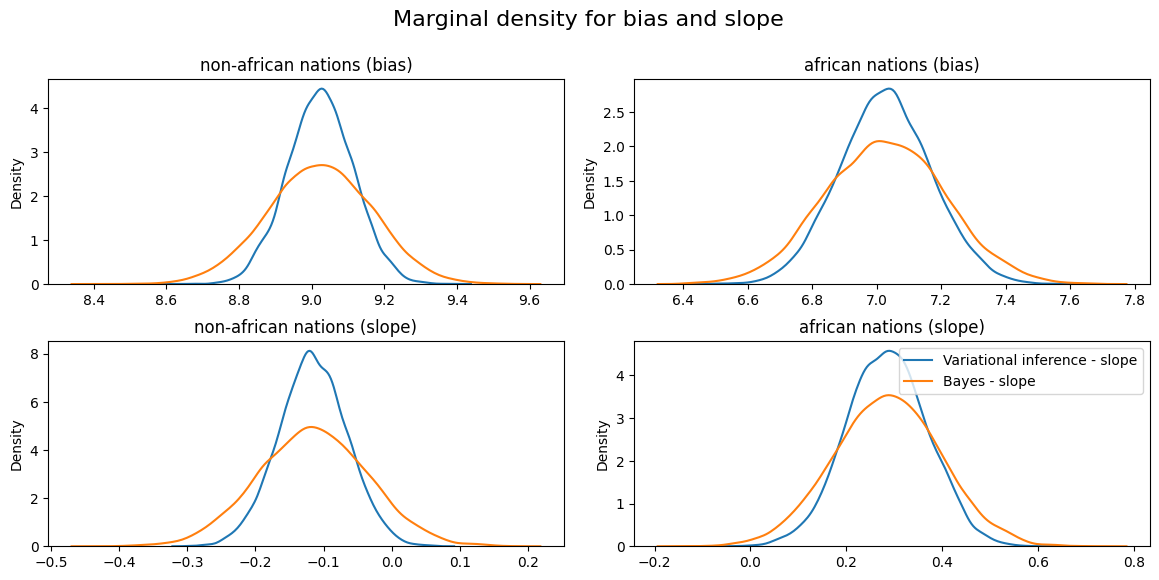

Mean field std for bias (non-african): 0.09074821246564498
Mean field std for slope (non-african): 0.050056301769860014
Bayes std for bias (non-african): 0.1442121491121023
Bayes std for slope (non-african): 0.08091185664490402
Mean field std for bias (african): 0.1423726293261547
Mean field std for slope (african): 0.0848292251564057
Bayes std for bias (african): 0.18677602475099672
Bayes std for slope (african): 0.11146485910746748


In [28]:
marginal_plot(model_bayes, model_mf)

## 3.2 Working with the posterior predictive

### 3.2.1 Get the posterior predictive 
Given the posterior distribution
$$
p({\bf w}| {\bf X}, {\bf y}, 1/\theta) =  {\mathcal N}({\bf w}| {\bf w}_p, \Sigma_p),
$$

where ${\bf w}_p$ and $\Sigma_p$ is the (approximate) posterior mean and (approximate) posterior covariance, respectively, we can calculate the posterior predictive distribution for a data point ${\bf x}$:
$$
p(y | {\bf x}, {\mathcal D}, 1/\theta) = \int \mathcal N(y|{\bf x}^T{\bf w}, 1/\theta) {\mathcal N}({\bf w}| {\bf w}_p, \Sigma_p),
$$


See, e.g., Murphy (2022), *Probabilistic machine learning: an introduction*. 

In [29]:
def get_posterior_predictive(model: dict, x_data_: np.array, theta: float = 1):
    """
    Calculate the posterior predictive distribution for the model.
    :param model: The model used for predictions. 
    :param x_data_: The input data for which the predictions should be made.
    :param theta: The prior precision for y.
    :return: A dictionary with the predictions containing also the variance terms.
    """
    predictions = {}

    for cont in model.keys():
        predictions[cont] = {}
        x_aug = np.c_[np.ones(x_data_[cont].shape[0]), x_data_[cont]]
        predictions[cont]['pred'] = model[cont]['w'] @ x_aug.T
        predictions[cont]['var'] = 1./theta + np.diagonal(x_aug @ model[cont]['cov'] @ x_aug.T)

    return predictions

In [30]:
preds = get_posterior_predictive(model_bayes, x_data)

### 3.2.2 Visualize the predictions

In [31]:
def predictive_plot(ax, x_data_: dict, predictions: dict, label: str = None):
    """
    Plot the posterior predictive distribution.
    """
    for idx, cont in enumerate(x_data_.keys()):
        sort_idx = np.argsort(x_data_[cont].flatten())
        sorted_input = x_data_[cont][sort_idx]
        preds = predictions[cont]['pred'][sort_idx]
        var = predictions[cont]['var'][sort_idx]
        ax[idx].fill_between(sorted_input.flatten(), preds - 2*np.sqrt(var),
                             preds + 2*np.sqrt(var), color='b', alpha=0.1)
        ax[idx].plot(sorted_input, preds, color='red', linewidth=2, label=label)
    return ax

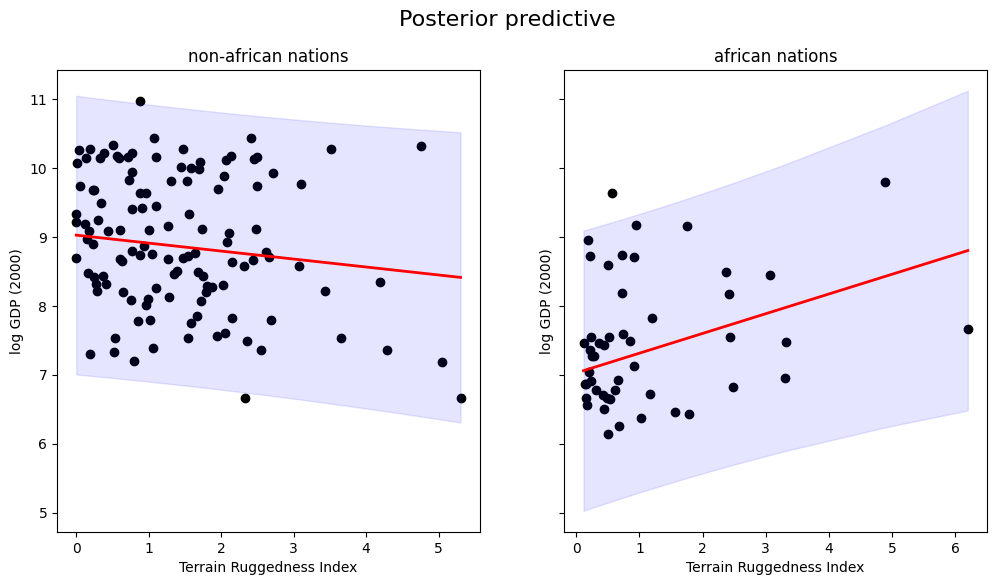

In [32]:
ax = prepare_figure('Posterior predictive')
predictive_plot(ax, x_data, preds)
plt.show()

### 3.2.2 Calculate log-likelihoods

We can evaluate the predictive qualities of our model using the log-likelihood:
$$
\log p({\bf y}|{\bf X},\text{posterior predictive mean and variance}) = \sum_{i=1}^N \log p(y_i|{\bf x}_i,\text{posterior predictive mean and variance})
$$

In [33]:
def get_ll(x_data_,y_data_: dict, model: dict):

    preds = get_posterior_predictive(model, x_data_)
    ll = {}
    for cont in model.keys():
        ll[cont] = 1./y_data_[cont].shape[0]*np.sum(norm.logpdf(y_data_[cont], loc=preds[cont]['pred'], scale=np.sqrt(preds[cont]['var'])))

    return ll

In [34]:
# Get the log-likelihood over the training set.
ll = get_ll(x_data, y_data, model_bayes)
print(ll)

{'non-african': -1.3750871001963823, 'african': -1.3377624555704464}


# 4. Exercises

In these exercises you should first familiarize yourself with the notebook, in particular try to connect the variational implementation to the slides previously covered.

Afterwards, explore and compare the models above by, e.g., varying the model hyperparameters and the data set sizes being used. Demonstrations are given below.

**Optionally:** Derive the updating rule for $q(w)$ and/or $q(b)$ 

# 5. Demonstrations/Solutions

The demonstrations below should only be considered inspiration for your own investigations into the properties of the model.

### Exploring the effect of changing the priors

Learned parameters:
For non-african nations
cov = 
[[ 0.04161589 -0.01810451]
 [-0.01810451  0.01292699]]
w = 
[ 8.83572092 -0.03325278]
For african nations
cov = 
[[ 0.06662856 -0.02571044]
 [-0.02571044  0.02411374]]
w = 
[6.79534246 0.37299022]


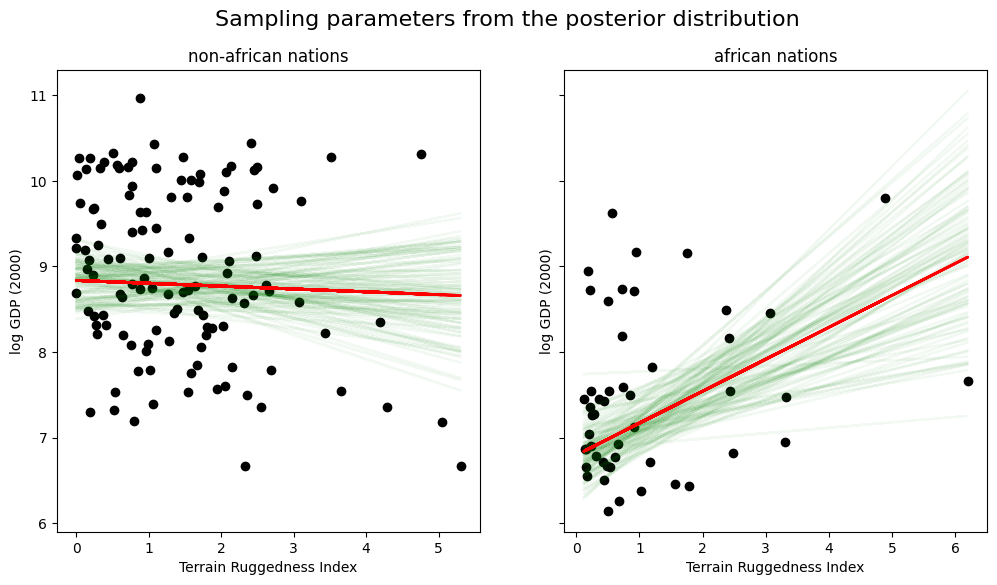

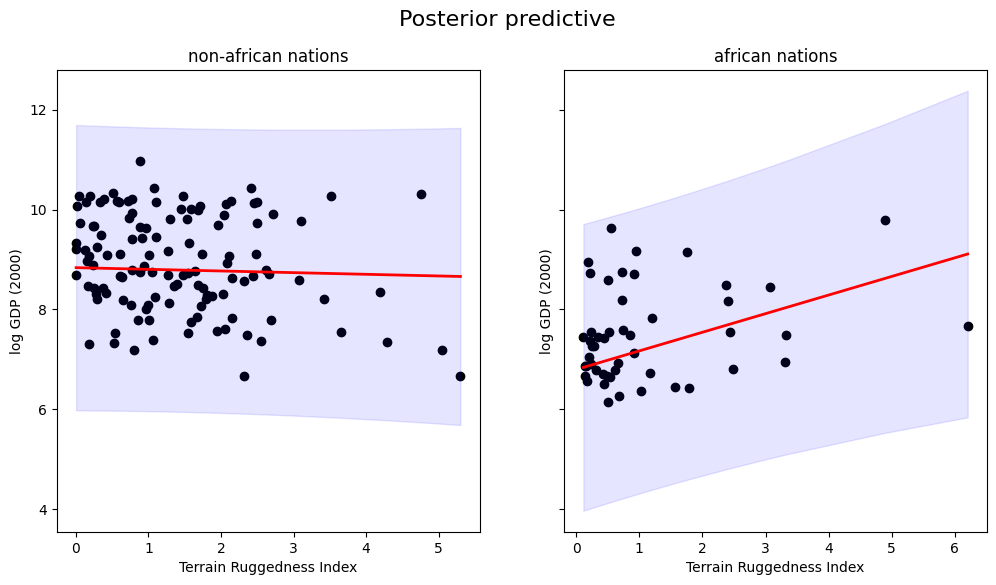

In [35]:
theta = 0.5
_model_ = bayes_solution(x_data, y_data, gamma_w=1, gamma_b=1, theta=theta, verbose=True)
ax = prepare_figure("Sampling parameters from the posterior distribution")
plot_model(ax, model=_model_, num_samples=100)
preds = get_posterior_predictive(_model_, x_data, theta=theta)
ax = prepare_figure('Posterior predictive')
predictive_plot(ax, x_data, preds)
plt.show()

### Experimenting with the priors and the amount of data used for training

In [36]:
x_train, y_train, x_test, y_test = get_data_subsets(x_data, y_data, 0.7, verbose=False)
x_train, y_train, _, _ = get_data_subsets(x_train, y_train, 0.1, verbose=False)

for cont in x_train.keys():
    print(f"{cont} entries: {x_train[cont].shape[0]}")
for cont in x_test.keys():
    print(f"{cont} entries: {x_test[cont].shape[0]}")

non-african entries: 8
african entries: 3
non-african entries: 37
african entries: 15


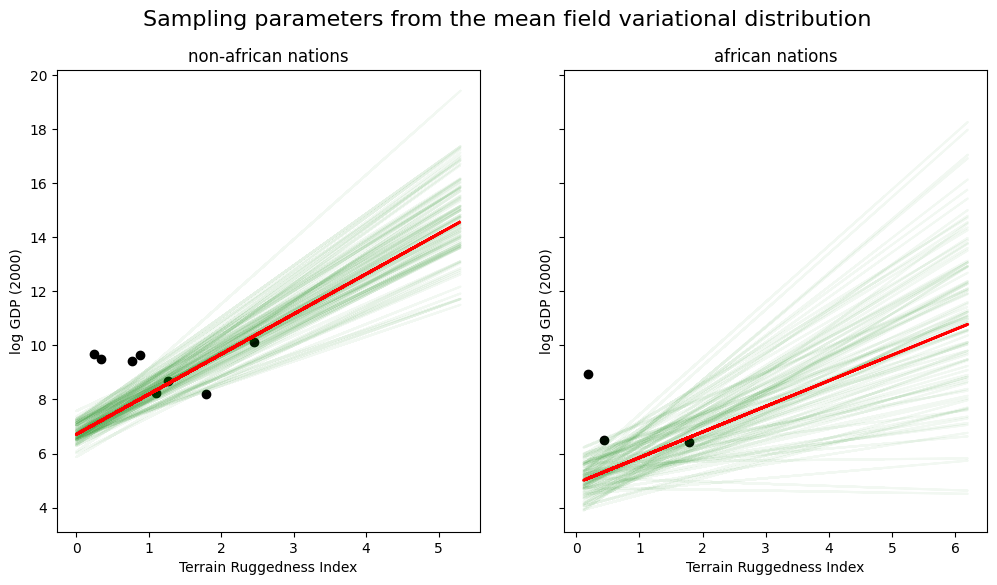

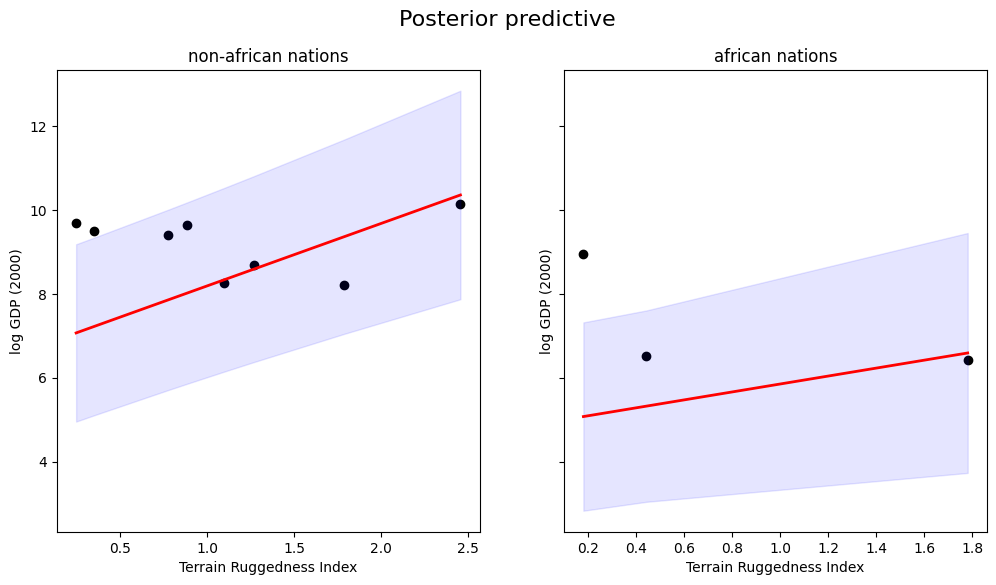

In [37]:
theta = 1
_model_vi = variational_solution(x_train, y_train, gamma_w=1, gamma_b=1, theta=theta, verbose=False)
ax = prepare_figure("Sampling parameters from the mean field variational distribution", x_train, y_train)
plot_model(ax, model=_model_vi, num_samples=100)
preds = get_posterior_predictive(_model_vi, x_train, theta=theta)
ax = prepare_figure('Posterior predictive', x_train, y_train)
predictive_plot(ax, x_train, preds)
plt.show()

### Varying the amount of data used for training

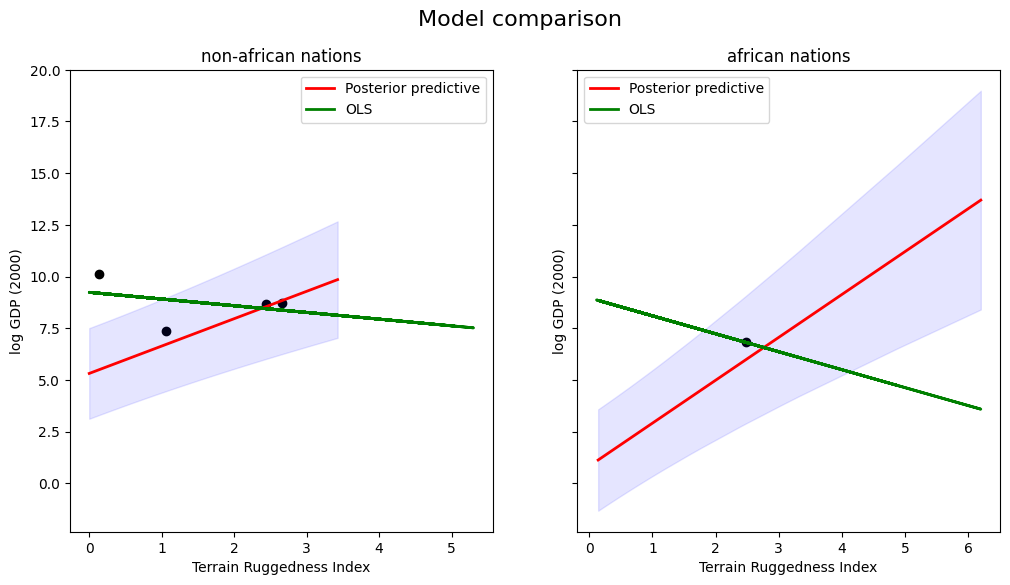

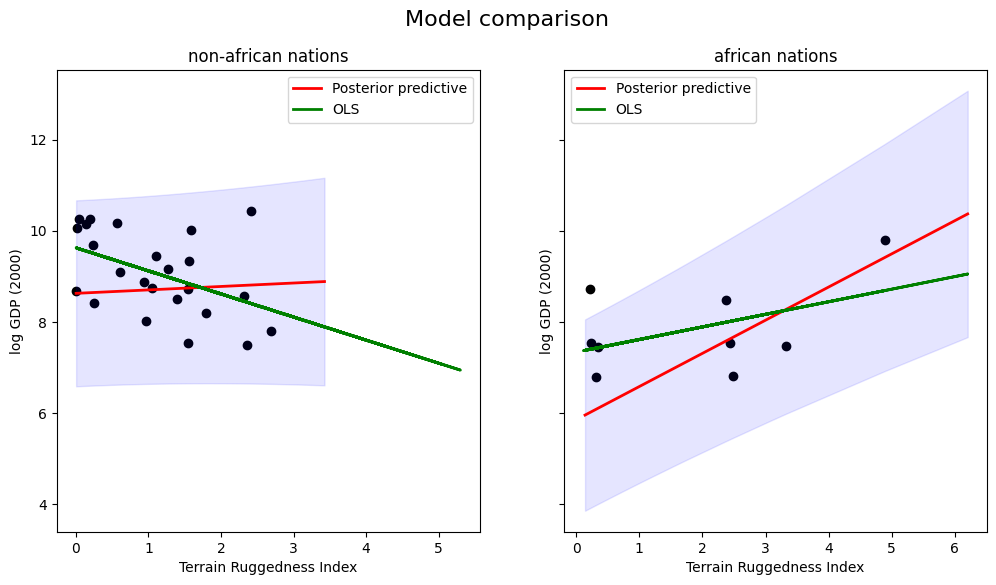

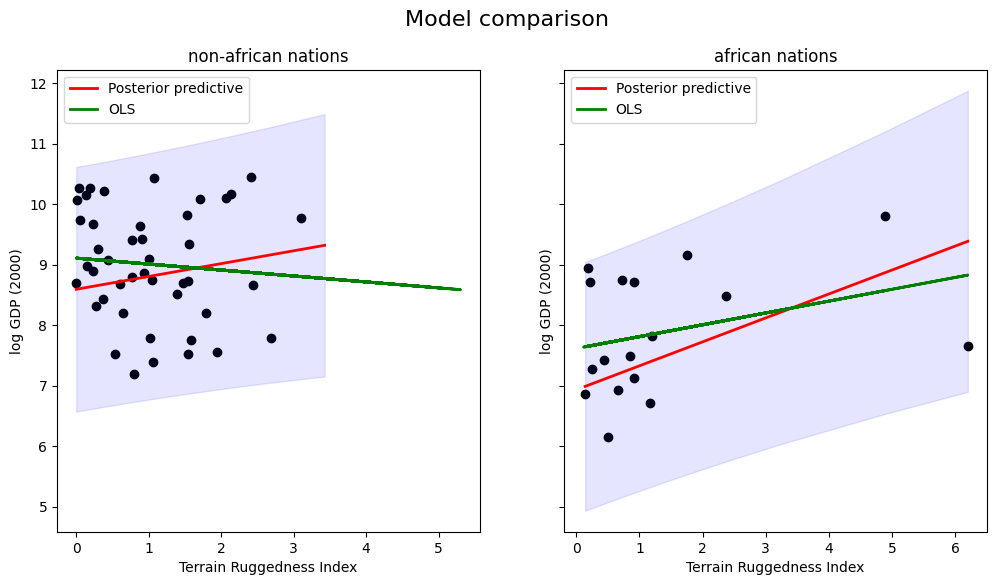

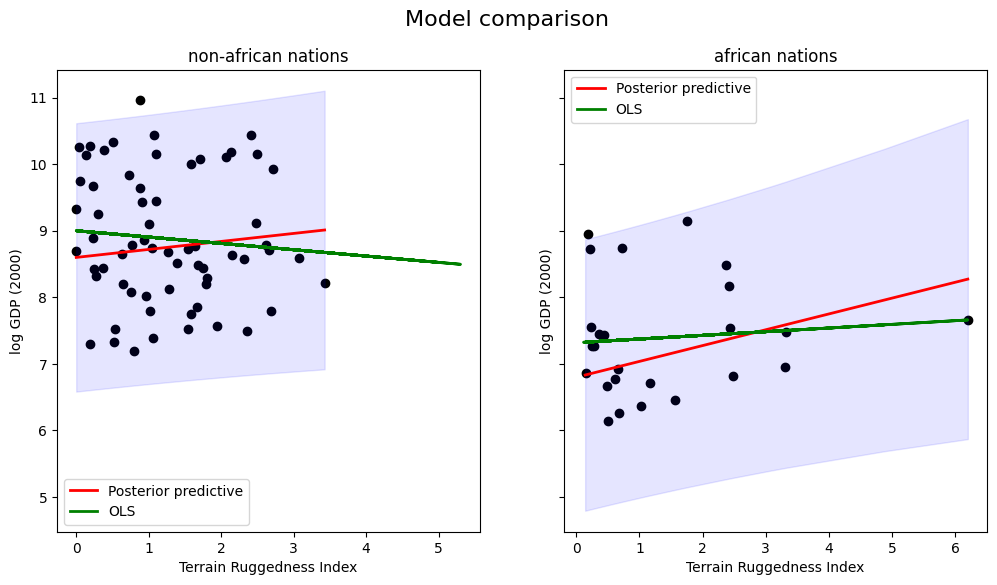

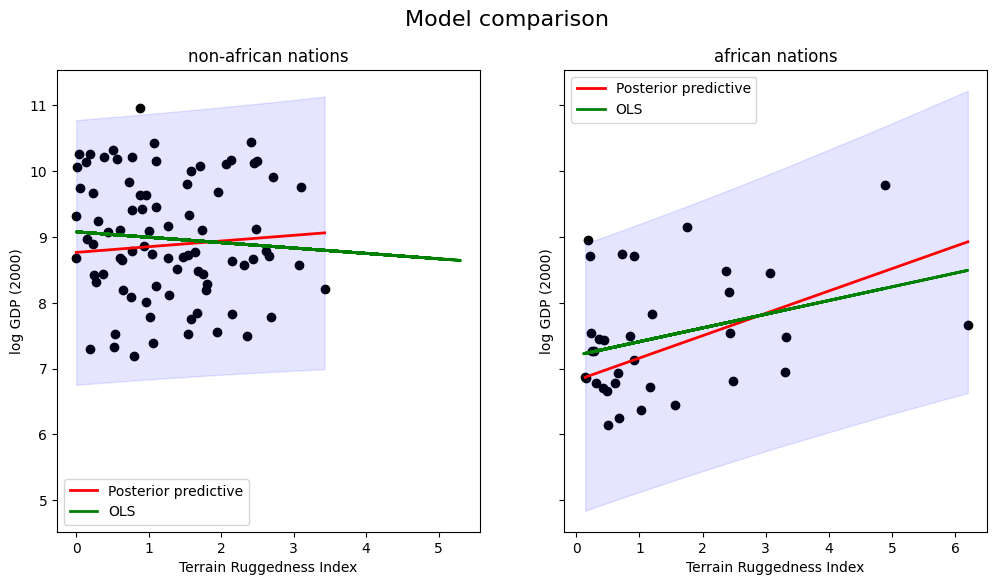

In [38]:
x_train, y_train, x_test, y_test = get_data_subsets(x_data, y_data, 0.7, verbose=False)

# We keep track of the log-likelihood calculations for future plotting
ll = {}
for cont in x_train.keys():
    ll[cont] = []

theta = 1     
#Data fraction to consider
data_fractions = np.linspace(0.05,1,5)
for f in data_fractions:
    _x_train, _y_train, _, _ = get_data_subsets(x_train, y_train, f, verbose=False)
    _model = variational_solution(_x_train, _y_train, gamma_w=1, gamma_b=1, theta=theta, verbose=False)
    _model_lr = least_squares_solution(_x_train, _y_train, verbose=False)
    for cont in x_train.keys():
        ll[cont].append(get_ll(x_test, y_test, _model)[cont])
    ax = prepare_figure('Model comparison', _x_train, _y_train)
    preds = get_posterior_predictive(_model, x_train, theta=theta)
    ax = predictive_plot(ax, x_train, preds, label='Posterior predictive')    
    plot_model(ax, model=_model_lr, line_color='green', label='OLS')
    plt.show()       

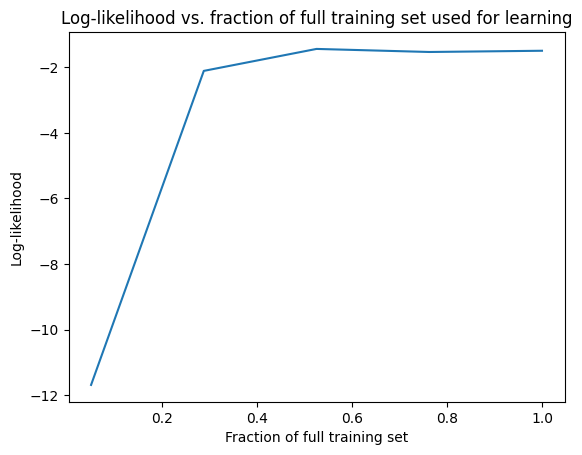

In [39]:
# Plot log-likelihood calculations
plt.plot(data_fractions, ll['african'])
plt.title('Log-likelihood vs. fraction of full training set used for learning')
plt.xlabel('Fraction of full training set')
plt.ylabel('Log-likelihood')
plt.show()